<a href="https://colab.research.google.com/github/kridtapon/WFO-MultiFrame-Momentum/blob/main/WFO_MultiFrame_Momentum.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.6/527.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.7/295.7 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.3 MB/s eta 0:00:00


[*********************100%***********************]  1 of 1 completed
<ipython-input-5-a0c806ac417f>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-a0c806ac417f>:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-5-a0c806ac417f>:48: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/in


Walk-Forward Optimization Results:
   Year   Best_Params  Test_Return
0  2020  (13, 29, 14)     0.403388
1  2021  (13, 29, 14)     0.491787
2  2022    (6, 28, 9)     0.089891
3  2023    (6, 27, 9)     0.380482
4  2024  (14, 27, 14)     0.287702
5  2025  (12, 20, 14)     0.000000
Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           405615.123395
Total Return [%]                       305.615123
Benchmark Return [%]                   302.647058
Max Gross Exposure [%]                      100.0
Total Fees Paid                       4198.057507
Max Drawdown [%]                         32.99703
Max Drawdown Duration                       257.0
Total Trades                                   10
Total Closed Trades                            10
Total Open Trades                               0
Open Trade PnL     

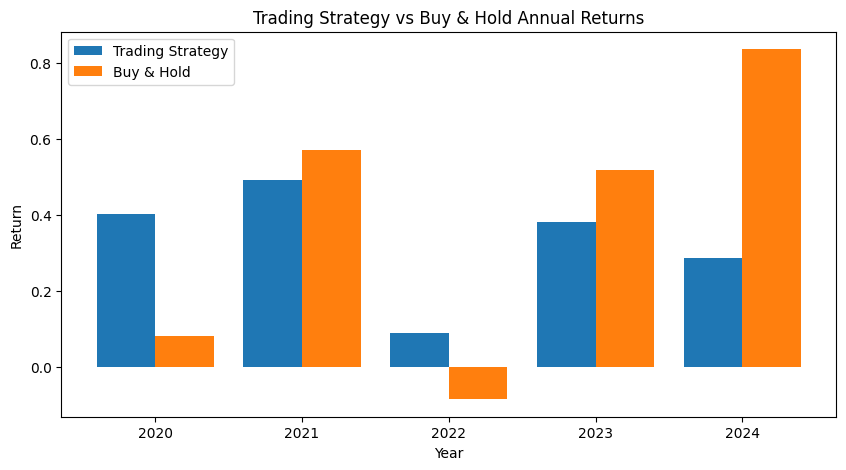

In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt

# Function to calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Walk-forward optimization with MACD on daily and weekly data
def walk_forward_optimization_macd(df, start_year, end_year):
    results = []

    # Define dynamic ranges for MACD parameters
    short_window_range = range(5, 15)  # Range for short window
    long_window_range = range(20, 31)  # Range for long window
    signal_window_range = range(5, 15)  # Range for signal window

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of MACD parameters for both timeframes
        for params in itertools.product(short_window_range, long_window_range, signal_window_range):
            short_window, long_window, signal_window = params

            # Calculate MACD for weekly and daily data
            weekly_data = train_data.resample('W').last()  # Resample weekly data
            weekly_data['MACD'], weekly_data['Signal'] = calculate_macd(weekly_data, short_window, long_window, signal_window)
            daily_data = train_data
            daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, short_window, long_window, signal_window)

            # Forward-fill weekly MACD to daily data
            weekly_data = weekly_data.reindex(daily_data.index, method='ffill')
            daily_data['HTF_Trend'] = weekly_data['MACD'] < weekly_data['Signal']  # Weekly trend confirmation

            # Generate entry and exit signals for the strategy
            entries = (daily_data['HTF_Trend']) & (daily_data['MACD'] > daily_data['Signal'])
            exits = (~daily_data['HTF_Trend']) & (daily_data['MACD'] < daily_data['Signal'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=daily_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (short_window, long_window, signal_window)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]
        weekly_data = yearly_data.resample('W').last()
        weekly_data['MACD'], weekly_data['Signal'] = calculate_macd(weekly_data, best_params[0], best_params[1], best_params[2])
        daily_data = yearly_data
        daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, best_params[0], best_params[1], best_params[2])

        # Forward-fill weekly MACD to daily data
        weekly_data = weekly_data.reindex(daily_data.index, method='ffill')
        daily_data['HTF_Trend'] = weekly_data['MACD'] < weekly_data['Signal']

        # Keep only the second year to avoid missing values from indicator calculation
        daily_data = daily_data[daily_data.index.year == test_year]

        entries = (daily_data['HTF_Trend']) & (daily_data['MACD'] > daily_data['Signal'])
        exits = (~daily_data['HTF_Trend']) & (daily_data['MACD'] < daily_data['Signal'])

        portfolio = vbt.Portfolio.from_signals(
            close=daily_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'APO' # APO!
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_macd(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]
    weekly_data = yearly_data.resample('W').last()
    weekly_data['MACD'], weekly_data['Signal'] = calculate_macd(weekly_data, params[0], params[1], params[2])
    daily_data = yearly_data
    daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, params[0], params[1], params[2])

    weekly_data = weekly_data.reindex(daily_data.index, method='ffill')
    daily_data['HTF_Trend'] = weekly_data['MACD'] < weekly_data['Signal']

    # Keep only the second year to avoid missing values from indicator calculation
    daily_data = daily_data[daily_data.index.year == year]

    entries = (daily_data['HTF_Trend']) & (daily_data['MACD'] > daily_data['Signal'])
    exits = (~daily_data['HTF_Trend']) & (daily_data['MACD'] < daily_data['Signal'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()


In [3]:
# Define the stock symbol and time period
symbol = 'APO'
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Filter Test Years
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Buy and Hold Performance Metrics
df_holding = df['Close']
pf = vbt.Portfolio.from_holding(df_holding, init_cash=100_000)
pf.stats()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



,Close
Start,2020-01-02 00:00:00
End,2024-12-31 00:00:00
Period,1258
Start Value,100000.0
End Value,402646.983056
Total Return [%],302.646983
Benchmark Return [%],302.646983
Max Gross Exposure [%],100.0
Total Fees Paid,0.0
Max Drawdown [%],53.479431


In [10]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Function to calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Define the stock symbol and time period
symbol = 'APO'  # Example stock symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the daily data
daily_df = yf.download(symbol, start=start_date, end=end_date)
daily_df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']

# Resample the daily data to weekly data (OHLCV: Open, High, Low, Close, Volume)
weekly_df = daily_df.resample('W').last()

# Calculate MACD for weekly (HTF) and daily (LTF)
weekly_df['MACD'], weekly_df['Signal'] = calculate_macd(weekly_df,6,27,9)
daily_df['MACD'], daily_df['Signal'] = calculate_macd(daily_df,6,27,9)

# Forward-fill weekly MACD to daily
weekly_df = weekly_df.reindex(daily_df.index, method='ffill')

daily_df['HTF_Trend'] = weekly_df['MACD'] < weekly_df['Signal']  # Weekly trend confirmation

# Entry Condition: Weekly MACD bullish & Daily MACD crossover bullish
daily_df['Entry'] = (daily_df['HTF_Trend']) & (daily_df['MACD'] > daily_df['Signal'])

# Exit Condition: Weekly MACD bearish & Daily MACD crossover bearish
daily_df['Exit'] = (~daily_df['HTF_Trend']) & (daily_df['MACD'] < daily_df['Signal'])

# Filter data for backtesting (2020-2025)
daily_df = daily_df[(daily_df.index.year >= 2023) & (daily_df.index.year <= 2023)]

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=daily_df['Close'],
    entries=daily_df['Entry'],
    exits=daily_df['Exit'],
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.11/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2023-01-03 00:00:00
End                           2023-12-29 00:00:00
Period                                        250
Start Value                              100000.0
End Value                           138048.232548
Total Return [%]                        38.048233
Benchmark Return [%]                    51.768718
Max Gross Exposure [%]                      100.0
Total Fees Paid                         493.31294
Max Drawdown [%]                        11.793294
Max Drawdown Duration                       104.0
Total Trades                                    2
Total Closed Trades                             2
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                100.0
Best Trade [%]                          27.640696
Worst Trade [%]                          8.185356
Avg Winning Trade [%]                   17.913026
Avg Losing Trade [%]                          NaN


[*********************100%***********************]  1 of 1 completed
<ipython-input-2-569924c6eefc>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, daily_short_window, daily_long_window, daily_signal_window)
<ipython-input-2-569924c6eefc>:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, daily_short_window, daily_long_window, daily_signal_window)
<ipython-input-2-5699


Walk-Forward Optimization Results:
   Year               Best_Params  Test_Return
0  2020   (11, 26, 15, 5, 20, 15)     0.407513
1  2021  (13, 24, 15, 15, 30, 15)     0.455491
2  2022     (9, 22, 15, 5, 30, 9)     0.022202
3  2023     (5, 22, 13, 5, 30, 9)     0.380482
4  2024    (15, 28, 15, 5, 30, 7)     0.299215
5  2025     (9, 20, 11, 5, 28, 5)     0.000000


<ipython-input-2-569924c6eefc>:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, params[3], params[4], params[5])
<ipython-input-2-569924c6eefc>:136: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, params[3], params[4], params[5])
<ipython-input-2-569924c6eefc>:139: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc

Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           371290.743442
Total Return [%]                       271.290743
Benchmark Return [%]                   302.646983
Max Gross Exposure [%]                      100.0
Total Fees Paid                        3632.15791
Max Drawdown [%]                         39.00984
Max Drawdown Duration                       359.0
Total Trades                                    9
Total Closed Trades                             9
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            88.888889
Best Trade [%]                          36.828647
Worst Trade [%]                        -18.104392
Avg Winning Trade [%]                   21.303496
Avg Losing Trade [%]                   -18.104392


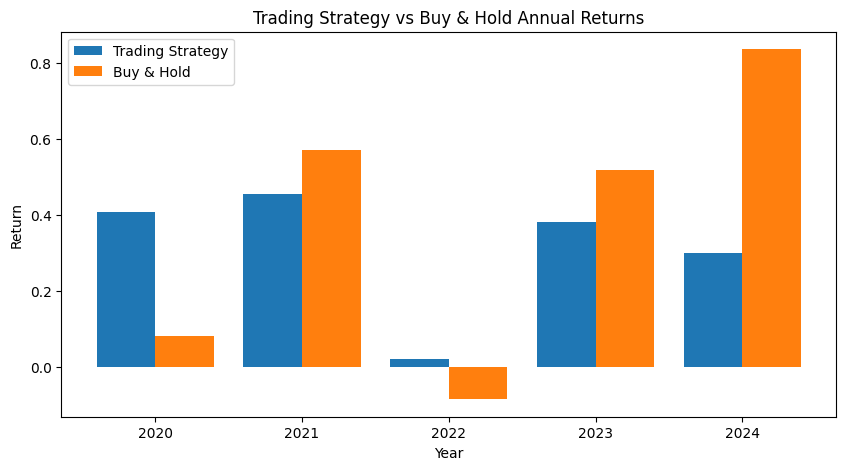

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
import itertools
import matplotlib.pyplot as plt

# Function to calculate MACD
def calculate_macd(df, short_window=12, long_window=26, signal_window=9):
    short_ema = df['Close'].ewm(span=short_window, adjust=False).mean()
    long_ema = df['Close'].ewm(span=long_window, adjust=False).mean()
    macd_line = short_ema - long_ema
    signal_line = macd_line.ewm(span=signal_window, adjust=False).mean()
    return macd_line, signal_line

# Walk-forward optimization with MACD on daily and weekly data
def walk_forward_optimization_macd(df, start_year, end_year):
    results = []

    # Define dynamic ranges for MACD parameters for weekly and daily data
    weekly_short_window_range = range(5, 16, 2)  # Range for weekly short window
    weekly_long_window_range = range(20, 31, 2)  # Range for weekly long window
    weekly_signal_window_range = range(5, 16, 2)  # Range for weekly signal window

    daily_short_window_range = range(5, 16, 2)  # Range for daily short window
    daily_long_window_range = range(20, 31, 2)  # Range for daily long window
    daily_signal_window_range = range(5, 16, 2)  # Range for daily signal window

    for test_year in range(start_year + 4, end_year + 1):
        train_start = test_year - 4
        train_end = test_year - 1
        test_start = test_year

        train_data = df[(df.index.year >= train_start) & (df.index.year <= train_end)]
        test_data = df[df.index.year == test_year]

        best_params = None
        best_performance = -np.inf

        # Loop through all combinations of MACD parameters for both timeframes
        for params in itertools.product(weekly_short_window_range, weekly_long_window_range, weekly_signal_window_range,
                                        daily_short_window_range, daily_long_window_range, daily_signal_window_range):
            weekly_short_window, weekly_long_window, weekly_signal_window, daily_short_window, daily_long_window, daily_signal_window = params

            # Calculate MACD for weekly and daily data
            weekly_data = train_data.resample('W').last()  # Resample weekly data
            weekly_data['MACD'], weekly_data['Signal'] = calculate_macd(weekly_data, weekly_short_window, weekly_long_window, weekly_signal_window)
            daily_data = train_data
            daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, daily_short_window, daily_long_window, daily_signal_window)

            # Forward-fill weekly MACD to daily data
            weekly_data = weekly_data.reindex(daily_data.index, method='ffill')
            daily_data['HTF_Trend'] = weekly_data['MACD'] < weekly_data['Signal']  # Weekly trend confirmation

            # Generate entry and exit signals for the strategy
            entries = (daily_data['HTF_Trend']) & (daily_data['MACD'] > daily_data['Signal'])
            exits = (~daily_data['HTF_Trend']) & (daily_data['MACD'] < daily_data['Signal'])

            # Backtest on training data
            portfolio = vbt.Portfolio.from_signals(
                close=daily_data['Close'],
                entries=entries,
                exits=exits,
                init_cash=100_000,
                fees=0.001
            )

            performance = portfolio.total_return()
            if performance > best_performance:
                best_performance = performance
                best_params = (weekly_short_window, weekly_long_window, weekly_signal_window,
                               daily_short_window, daily_long_window, daily_signal_window)

        # Test with the best parameters on the test data
        yearly_data = df[(df.index.year >= test_year - 1) & (df.index.year <= test_year)]
        weekly_data = yearly_data.resample('W').last()
        weekly_data['MACD'], weekly_data['Signal'] = calculate_macd(weekly_data, best_params[0], best_params[1], best_params[2])
        daily_data = yearly_data
        daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, best_params[3], best_params[4], best_params[5])

        # Forward-fill weekly MACD to daily data
        weekly_data = weekly_data.reindex(daily_data.index, method='ffill')
        daily_data['HTF_Trend'] = weekly_data['MACD'] < weekly_data['Signal']

        # Keep only the second year to avoid missing values from indicator calculation
        daily_data = daily_data[daily_data.index.year == test_year]

        entries = (daily_data['HTF_Trend']) & (daily_data['MACD'] > daily_data['Signal'])
        exits = (~daily_data['HTF_Trend']) & (daily_data['MACD'] < daily_data['Signal'])

        portfolio = vbt.Portfolio.from_signals(
            close=daily_data['Close'],
            entries=entries,
            exits=exits,
            init_cash=100_000,
            fees=0.001
        )

        results.append({
            'Year': test_year,
            'Best_Params': best_params,
            'Test_Return': portfolio.total_return()
        })

    return pd.DataFrame(results)

# Define the stock symbol and time period
symbol = 'APO'  # APO!
start_date = '2015-01-01'
end_date = '2025-01-01'

# Download the stock data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Perform walk-forward optimization
results = walk_forward_optimization_macd(df, 2016, 2025)

# Display results
print("\nWalk-Forward Optimization Results:")
print(results)

# Combine signals into a single portfolio
combined_entries = pd.Series(False, index=df.index)
combined_exits = pd.Series(False, index=df.index)

for _, row in results.iterrows():
    year = row['Year']
    params = row['Best_Params']

    yearly_data = df[(df.index.year >= year - 1) & (df.index.year <= year)]
    weekly_data = yearly_data.resample('W').last()
    weekly_data['MACD'], weekly_data['Signal'] = calculate_macd(weekly_data, params[0], params[1], params[2])
    daily_data = yearly_data
    daily_data['MACD'], daily_data['Signal'] = calculate_macd(daily_data, params[3], params[4], params[5])

    weekly_data = weekly_data.reindex(daily_data.index, method='ffill')
    daily_data['HTF_Trend'] = weekly_data['MACD'] < weekly_data['Signal']

    # Keep only the second year to avoid missing values from indicator calculation
    daily_data = daily_data[daily_data.index.year == year]

    entries = (daily_data['HTF_Trend']) & (daily_data['MACD'] > daily_data['Signal'])
    exits = (~daily_data['HTF_Trend']) & (daily_data['MACD'] < daily_data['Signal'])

    combined_entries.loc[entries.index] = entries
    combined_exits.loc[exits.index] = exits

# Filter data for testing period only
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
combined_entries = combined_entries[(combined_entries.index.year >= 2020) & (combined_entries.index.year <= 2025)]
combined_exits = combined_exits[(combined_exits.index.year >= 2020) & (combined_exits.index.year <= 2025)]

# Backtest using the combined signals
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=combined_entries,
    exits=combined_exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

# Get unique years in the dataset
years = sorted(df.index.year.unique())

# Store annual returns
strategy_returns = {}
buy_and_hold_returns = {}

for year in years:
    yearly_data = df[df.index.year == year]

    if not yearly_data.empty:  # Check if data exists for the year
        # Buy & Hold Return
        start_price = yearly_data.iloc[0]['Close']
        end_price = yearly_data.iloc[-1]['Close']
        buy_and_hold_return = (end_price - start_price) / start_price
        buy_and_hold_returns[year] = buy_and_hold_return

        # Strategy Return
        strategy_returns[year] = results[results['Year'] == year]['Test_Return'].values[0]

# Plot bar chart
plt.figure(figsize=(10, 5))
bar_width = 0.4
plt.bar([y - bar_width/2 for y in strategy_returns.keys()], strategy_returns.values(), width=bar_width, label="Trading Strategy")
plt.bar([y + bar_width/2 for y in buy_and_hold_returns.keys()], buy_and_hold_returns.values(), width=bar_width, label="Buy & Hold")

plt.xlabel("Year")
plt.ylabel("Return")
plt.title("Trading Strategy vs Buy & Hold Annual Returns")
plt.legend()
plt.xticks(list(strategy_returns.keys()))

plt.show()
